In [9]:
import re 
import sys
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob 
import pickle
import string
import config
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from itertools import dropwhile
from autocorrect import spell
from nltk.corpus import stopwords
from string import punctuation

In [10]:
test = pd.read_pickle('tweets_5_30_6PM_clean.pkl')

In [11]:
test.head()

,text,analysis,sentiment
0,priceless time with my boy #unt #untalumni,1.00,positive
1,#togetherwe make old pop culture references,0.10,neutral
2,hey rangers is the reason we cant get a mike m...,-0.05,neutral
3,a home game is coming,-0.40,neutral
4,lets go rangers rangers team total over 55 240...,0.00,neutral


In [12]:
def clean_tweets(token):
    SPECIAL_CHARS = '& lt; |& lt; |& amp; |:'
    HANDLE = '@\ w +' 
    LINK = 'https:// t\. co/\ w +'
    

    token = re.sub( HANDLE, ' ', token) 
    token = re.sub( LINK, ' ', token) 
    token = re.sub( SPECIAL_CHARS, ' ', token)

    return token
                  
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('English'))
    
    # remove common words and tokenize
    list1 = ['RT','rt']
    stoplist = stopwords.words('english') + list(punctuation) + list1
    
    return [word for word in tokens if word not in stoplist]

def remove_numbers(tokens):
    # Remove number tokens
     return [x for x in tokens if not (x.isdigit() 
                                         or x[0] == '-' and x[1:].isdigit())]
def correct_spelling(tokens):
    return [spell(word) for word in tokens]

def get_ngrams(tokens, number, top):
    frequencies = Counter([])
    for row in tokens:
        counts = ngrams(row, number)
        frequencies += Counter(counts)
        
    print("Number of " + str(number) )
    print("Most common ngrams:")
    for value, count in frequencies.most_common(top):
        print(value, count)
    
    return frequencies
def get_stems(tokens):
    stemmer= PorterStemmer()
    stems=[]
    for word in tokens:
        stems.append(stemmer.stem(word))
    return stems
    
def apply_lemmatization(tokens):
    lemmatizer=WordNetLemmatizer()
    lemmatization = []
    for word in tokens:
        lemmatization.append(lemmatizer.lemmatize(word))
    return lemmatization

def apply_threshold(ngrams, threshold):
    for key, count in dropwhile(lambda key_count: key_count[1] >= threshold, ngrams.most_common()):
        del ngrams[key]
    return ngrams

In [13]:
test['clean_tweets'] = test.text.apply(clean_tweets)
test['tokens'] = test.clean_tweets.apply(nltk.word_tokenize) 
test['non_stopwords'] = test.tokens.apply(remove_stopwords)
test['non_numbers'] = test.apply(lambda row: remove_numbers(row['non_stopwords']), axis=1)

test['stems'] = test.apply(lambda row: get_stems(row['non_numbers']), axis=1)
test['lemmat'] = test.apply(lambda row: apply_lemmatization(row['stems']), axis=1)
test['clean'] = test.lemmat.apply(', '.join)

### Number of ngrams in all tweets:

In [ ]:
for gram in range(10):
    get_ngrams(test.non_numbers, gram, 10)
    print()

In [14]:
from gensim.models.coherencemodel import CoherenceModel

def calculate_coherence_score(documents, dictionary, model):
    coherence_model = CoherenceModel(model=model, 
                                     texts=documents, 
                                     dictionary=dictionary, 
                                     coherence='c_v')
    return coherence_model.get_coherence()

def get_coherence_values(start, stop):
    for num_topics in range(start, stop):
        print(f'\nCalculating coherence for {num_topics} topics')
        ldamodel = LdaModel(corpus, 
                    num_topics = num_topics, 
                    id2word=dictionary, passes=2)
        coherence = calculate_coherence_score(texts, 
                                              dictionary, 
                                              ldamodel)
        yield coherence

In [28]:

test['texts'] = test.tokens.apply(remove_stopwords)
test['texts'] = test.apply(lambda row: remove_numbers(row['texts']), axis=1)

# texts = test.apply(lambda row: get_stems(row['texts']), axis=1)
# texts = test.apply(lambda row: apply_lemmatization(row['texts']), axis=1)

In [29]:
from gensim import corpora, models, similarities

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [30]:
from gensim.models import LdaModel

min_topics, max_topics = 1,30
coherence_scores = list(get_coherence_values(min_topics, max_topics))


Calculating coherence for 1 topics

Calculating coherence for 2 topics

Calculating coherence for 3 topics

Calculating coherence for 4 topics

Calculating coherence for 5 topics

Calculating coherence for 6 topics

Calculating coherence for 7 topics

Calculating coherence for 8 topics

Calculating coherence for 9 topics

Calculating coherence for 10 topics

Calculating coherence for 11 topics

Calculating coherence for 12 topics

Calculating coherence for 13 topics

Calculating coherence for 14 topics

Calculating coherence for 15 topics

Calculating coherence for 16 topics

Calculating coherence for 17 topics

Calculating coherence for 18 topics

Calculating coherence for 19 topics

Calculating coherence for 20 topics

Calculating coherence for 21 topics

Calculating coherence for 22 topics

Calculating coherence for 23 topics

Calculating coherence for 24 topics

Calculating coherence for 25 topics

Calculating coherence for 26 topics

Calculating coherence for 27 topics

Calculati

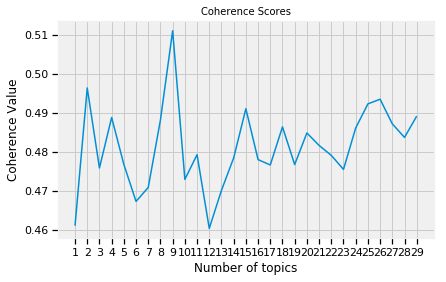

In [31]:
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.ticker import MaxNLocator

style.use('fivethirtyeight')

%matplotlib inline

import seaborn as sns
sns.set_context("notebook")

x = [int(i) for i in range(min_topics, max_topics)]

sns.lineplot(x, coherence_scores)
plt.xticks(x)
plt.xlabel('Number of topics')
plt.ylabel('Coherence Value')
plt.title('Coherence Scores', fontsize=10);

#plt.xaxis.set_major_locator(MaxNLocator(integer=True))

In [32]:

tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model
corpus_tfidf = tfidf[corpus]  # step 2 -- use the model to transform vectors

In [33]:
total_topics = 9

In [34]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics, passes=30)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

In [35]:
lda.show_topics(total_topics,total_topics)

[(0,
  '0.058*"ju" + 0.037*"time" + 0.030*"current" + 0.023*"get" + 0.021*"like" + 0.019*"team" + 0.019*"woh" + 0.016*"he" + 0.012*"thank"'),
 (1,
  '0.252*"ranger" + 0.105*"togetherw" + 0.094*"2nd-place" + 0.054*"texa" + 0.048*"nice" + 0.045*"basebal" + 0.039*"final" + 0.027*"marin" + 0.021*"follow"'),
 (2,
  '0.070*"go" + 0.058*"basebal" + 0.050*"play" + 0.050*"josh" + 0.047*"hamilton" + 0.047*"player" + 0.045*"never" + 0.045*"ive" + 0.044*"power"'),
 (3,
  '0.152*"love" + 0.077*"r" + 0.053*"lik" + 0.053*"fela" + 0.053*"cgi" + 0.053*"practis" + 0.053*"the" + 0.053*"dancimg" + 0.052*"night"'),
 (4,
  '0.097*"game" + 0.066*"good" + 0.066*"yall" + 0.065*"tonight" + 0.061*"guy" + 0.055*"happi" + 0.052*"step" + 0.035*"steak" + 0.028*"back"'),
 (5,
  '0.207*"togetherw" + 0.090*"win" + 0.073*"column" + 0.070*"look" + 0.062*"w" + 0.045*"last" + 0.039*"seri" + 0.037*"4-game" + 0.020*"hello"'),
 (6,
  '0.086*"joey" + 0.037*"gallo" + 0.031*"first" + 0.029*"row" + 0.028*"pitch" + 0.026*"singl" +

In [36]:
from collections import OrderedDict

data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
#data_lda

import pandas as pd

df_lda = pd.DataFrame(data_lda)
print(df_lda.shape)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(205, 9)
(9, 205)


In [37]:
df_lda

,'',2nd-place,4-game,9th-in,``,amp,angel,arlington,averag,awesom,...,well,win,woh,world,would,wwwwin,wwwwwin,yall,year,yeesh
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.018869,0.000000,0.01011,0.000000,0.000000,0.000000,0.000000,0.00000
1,0.000000,0.093736,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011971,0.000000,0.003136,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
3,0.023615,0.000000,0.000000,0.000000,0.024239,0.000000,0.000000,0.000000,0.000000,0.01051,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012654,0.000000,0.00000,...,0.006084,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.066246,0.000000,0.00000
5,0.000000,0.000000,0.036708,0.005123,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.089742,0.000000,0.000000,0.00000,0.007991,0.005988,0.000000,0.000000,0.00000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.015337,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.020336,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.012238,0.06079


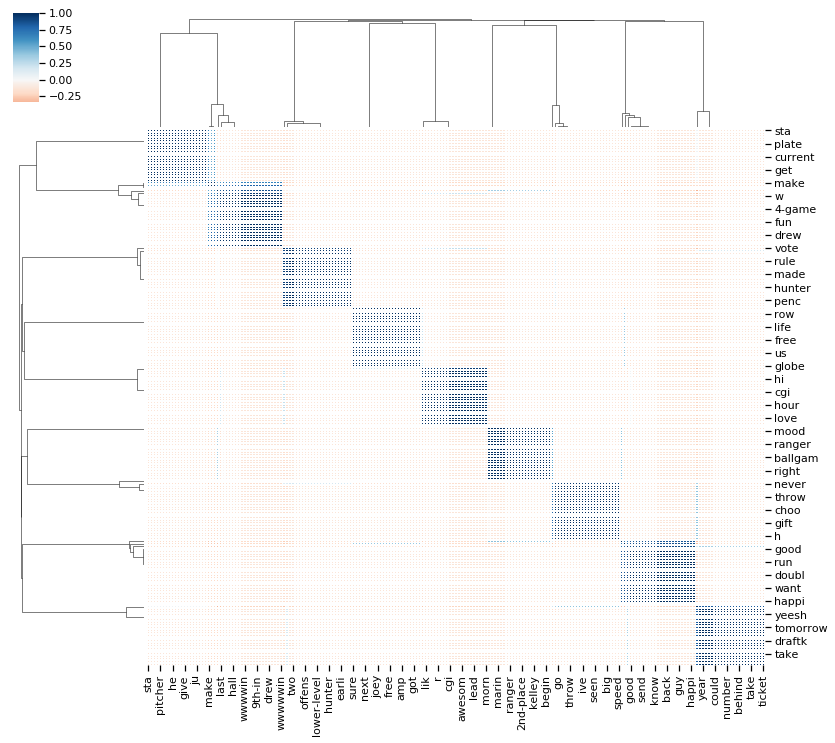

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g=sns.clustermap(df_lda.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [39]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='pcoa')
panel

/anaconda3/envs/py36/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.095482  0.006483       1        1  33.569298
6      0.090330 -0.125670       2        1  14.811744
4      0.214583 -0.017226       3        1  13.410944
1     -0.283969  0.058054       4        1   9.533458
5     -0.252693 -0.092797       5        1   5.738179
7     -0.099555 -0.066533       6        1   5.734104
8      0.203203  0.095432       7        1   5.734095
3      0.051789 -0.222993       8        1   5.734094
2     -0.019170  0.365251       9        1   5.734092, topic_info=     Category        Freq            Term       Total  loglift  logprob
17    Default  289.000000          ranger  289.000000  30.0000  30.0000
10    Default  289.000000       togetherw  289.000000  29.0000  29.0000
23    Default  187.000000            game  187.000000  28.0000  28.0000
211   Default  104.000000            love  104.000000  27.0000  27.0000
460   Default  153.000000            joey  153.000000  26.0000  26.0000
1630  Default   91.000000       goodnight   91.000000  25.0000  25.0000
3971  Default  107.000000       2nd-place  107.000000  24.0000  24.0000
1283  Default  233.000000              ju  233.000000  23.0000  23.0000
21    Default  106.000000            yall  106.000000  22.0000  22.0000
121   Default  104.000000         tonight  104.000000  21.0000  21.0000
308   Default   99.000000             guy   99.000000  20.0000  20.0000
180   Default  114.000000            good  114.000000  19.0000  19.0000
27    Default   78.000000              go   78.000000  18.0000  18.0000
127   Default   91.000000         basebal   91.000000  17.0000  17.0000
507   Default   89.000000           happi   89.000000  16.0000  16.0000
53    Default   61.000000             win   61.000000  15.0000  15.0000
299   Default   83.000000            step   83.000000  14.0000  14.0000
139   Default   58.000000            take   58.000000  13.0000  13.0000
570   Default   53.000000               r   53.000000  12.0000  12.0000
959   Default   50.000000          column   50.000000  11.0000  11.0000
66    Default   68.000000           night   68.000000  10.0000  10.0000
41    Default   48.000000            look   48.000000   9.0000   9.0000
331   Default   64.000000            texa   64.000000   8.0000   8.0000
2     Default  153.000000            time  153.000000   7.0000   7.0000
24    Default   78.000000            home   78.000000   6.0000   6.0000
54    Default   55.000000            nice   55.000000   5.0000   5.0000
286   Default  119.000000         current  119.000000   4.0000   4.0000
365   Default   44.000000             ill   44.000000   3.0000   3.0000
1171  Default   44.000000  hellowincolumn   44.000000   2.0000   2.0000
648   Default   66.000000           gallo   66.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
995    Topic9   29.705984          physic   29.872728   2.8531  -3.1431
993    Topic9   29.649628            born   29.816370   2.8531  -3.1450
997    Topic9   29.605276           speed   29.772017   2.8531  -3.1465
994    Topic9   29.554682        instinct   29.721422   2.8531  -3.1482
535    Topic9   12.754524             big   12.921284   2.8458  -3.9885
1546   Topic9    8.241108           angel    8.407987   2.8387  -4.4253
533    Topic9    4.546100            grow    4.712873   2.8227  -5.0201
360    Topic9    2.554618          inning    2.721478   2.7955  -5.5965
1757   Topic9    2.158596          averag    2.325426   2.7843  -5.7650
1199   Topic9    2.042838            choo    2.209685   2.7802  -5.8201
448    Topic9    1.998342           guess    2.165137   2.7786  -5.8421
240    Topic9   34.734211            play   37.961315   2.7699  -2.9867
1753   Topic9    1.638105              la    1.805019   2.7617  -6.0409
985    Topic9    1.635241         nashvil    1.801996   2.7616  -6.0426
550    Topic9    1.571103           three    1.7380